**Questions**
1. How do you have statistics evaluating players to predict how good they will do that are different based on position?
    - Solution A: Evaluate positions separately with ML Models, and have the projected points for each player be passed into the draft bot 
    - Solution B: Include player statistics with draft data, and have reinforcement use those to choose who to draft, instead of having a ppg number. 
                  This solution does have issues, as different positions will have different statistics, as will rookies.
    - Solution C: Give the reinforcement learning agent the ML predicted ppg as well as player statistics. The RL agent can learn how much trust to place in the projection
    - Solution D: Dynamic Season Simulation: Instead of giving just a single projected PPG, simulate season outcomes stochastically and return mean_ppg, std_ppg, ceiling, floor, boom_probability.
                  Agent can learn to balance risk/reward based on draft context
    - Solution E: Latent Player Embeddings: Train an unsupervised embedding model (e.g. autoencoder) over raw player stats to create compact player vectors. Can be helpful because we have many statistics.
    - Solution F: Deep learning with MLP, a Recurrent Model (LSTM/GRU), or a Transformer

    - Problem 1b: In solutions where we pass the data directly to reinforcement learning, statistics will not be common amongst different positions.
        - Solution A: Make each row have all possible statistics and fill irrelevant datapoints with 0, null, or -1
        - Solution B: Build separate feature encoders (small neural nets) for each position type (QB, RB, WR, TE), and pass the output of these encoders to a shared draft policy network. Pretty much making vectors separately and then pass them to one
                      decision-making policy?
        - Solution C: Instead of having separate encoders for each position like Solution B, you have one position aware encoder.
        - Solution D: Positional Streams (Transformer-Style): Model each position group as a separate input stream - like in multimodal learning - and aggregate the ouptuts across all positions when making the decision. (Don't get this)

2. How will we deal with Rookies?
    - Solution A: Evaluate rookies in a separate database, and base projections over college statistics, draft capital, and other nfl team statistics
3. How do we factor in bench? How do we make it so they aren't just going to want to pick QB's for bench spots?
    - Solution A: Make position limits for bench
    - Solution B: Normalize the ppg for bench players so the ppg factored in will be in relation to position average
4. How do we execute the draft? We want the Agent to only be one spot, so we need a bot to perform the draft for all other positions.
    - Solution A: Only use ADP and position needs for draft choices to non-agent positions. Need to have a random-esque parameter to determine how unpredictably 
                  the non-agent positions can draft, they can't always choose highest ADP player, we want some variation. Going to just need to play around with that 
                  random parameter, would be nice if it could get more and more loose the later the draft goes.




**Ideas**
- Would be cool to have a risk setting to prioritize high risk high reward players or to play things safer, using standard deviation
- Add volatility to statistics, the standard deviation of weekly points to show how reliable a player is.
- Deep Learning Ideas
    - Use a deep policy network (MLP or Transformer) to take draft actions. Represent the player pool using deep encoders or learned embeddings. Encode your current roster as a deep vector and feed it into the policy. Use PPO or SAC for training
    - Draft Pool Representation with Transformers or Attention

**Problems**



### Data Model
##### player_draft_data
- player_name
- position
- team_name
- season
- adp
- fantasy_ppg
##### qb_evaluation_data
- player_name
- position
- team_name
- season
- ... evaluation stats ...
- Result: projected PPG
##### rb_evaluation_data
- player_name
- position
- team_name
- season
- ... evaluation stats ...
- Result: projected PPG
##### wr_evaluation_data
- player_name
- position
- team_name
- season
- ... evaluation stats ...
- Result: projected PPG
##### te_evaluation_data
- player_name
- position
- team_name
- season
- ... evaluation stats ...
- Result: projected PPG


### Draft Set-Up
- Parameters:
    - starting_qb_num
    - starting_rb_num
    - starting_wr_num
    - starting_flex_num
    - starting_te_num
    - bench_num
    - team_count
    - draft_position

Sleeper user request

In [2]:
import requests

url = "https://api.sleeper.app/v1/user/scottbwinner" 
response = requests.get(url)

user = response.json()

user['user_id']

'607733942388322304'

Getting league ID's from sleeper

In [17]:
seasons = ['2020', '2021', '2022', '2023', '2024']
league_ids = []

for season in seasons:
    url = "https://api.sleeper.app/v1/user/607733942388322304/leagues/nfl/" + season 
    response = requests.get(url)
    leagues = response.json()
    for league in leagues:
        if (league['name'] == 'Data Pipeline'):
            league_ids.append(league['league_id'])

print(league_ids)

['605900005152231424', '726160118135263232', '857666474519695360', '991402385438244864', '1100836812483829760']


Retrieving draft data for Data Pipeline league

In [ ]:

draft_ids = {}
for league_id in league_ids:
    url = "https://api.sleeper.app/v1/league/" + league_id + "/drafts"
    response = requests.get(url).json()
    draft_ids[response[0]['season']] = (response[0]['draft_id'])  # Assuming there's only one draft per league



{'2020': '605900006494400512', '2021': '726160118135263233', '2022': '857666474519695361', '2023': '991402385438244865', '2024': '1100836812483829761'}


In [58]:
raw_draft_data = {}
for season in draft_ids:
    url = "https://api.sleeper.app/v1/draft/" + draft_ids[season] + "/picks"
    response = requests.get(url)
    raw_draft_data[season] = (response.json())

Process draft data and convert to csv files

In [59]:
import pandas as pd

person_key = {'863297584993771520': 'Devin', '607733942388322304': 'Scott', '608049714767679488': 'James', '466691579390717952': 'Kiyan', '607791058134327296': 'Zack', '605824057266483200': 'Nate', '608106839443337216': 'Eric', '608106896582320128': 'Adam', '595337987282231296': 'Trent', '608108727580561408': 'Ira', '608160107410305024': 'Logan'}
season_key = {'2020': '2020-21', '2021': '2021-22', '2022': '2022-23', '2023': '2023-24', '2024': '2024-25'}

for season in raw_draft_data:
    df = pd.DataFrame(raw_draft_data[season])
    df['name'] = df['metadata'].apply(lambda x: x['first_name']) + ' ' + df['metadata'].apply(lambda x: x['last_name'])
    df['position'] = df['metadata'].apply(lambda x: x['position'])
    df['team'] = df['metadata'].apply(lambda x: x['team'])
    df['years_experience'] = df['metadata'].apply(lambda x: x['years_exp'])
    df['injury_status'] = df['metadata'].apply(lambda x: x['injury_status'])
    df['Season'] = season_key[season]
    df.drop(columns=['metadata'], inplace=True)
    for key in person_key:
        df = df.replace(key, person_key[key])
    df.to_csv('./draft_data/dp_draft_data_' + season + '.csv', index=False)

df


,draft_id,draft_slot,is_keeper,pick_no,picked_by,player_id,reactions,roster_id,round,name,position,team,years_experience,injury_status,Season
0,1100836812483829761,1,None,1,Devin,4034,None,9,1,Christian McCaffrey,RB,SF,7,Questionable,2024-25
1,1100836812483829761,2,None,2,Scott,6786,None,2,1,CeeDee Lamb,WR,DAL,4,,2024-25
2,1100836812483829761,3,None,3,James,9509,"{'605824057266483200': ['poop'], '607733942388...",5,1,Bijan Robinson,RB,ATL,1,,2024-25
3,1100836812483829761,4,None,4,Kiyan,3321,"{'466691579390717952': ['poop'], '605824057266...",10,1,Tyreek Hill,WR,MIA,8,Questionable,2024-25
4,1100836812483829761,5,None,5,Zack,7564,{'605824057266483200': ['smart']},3,1,Ja'Marr Chase,WR,CIN,3,,2024-25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,1100836812483829761,6,None,146,Nate,SEA,None,1,15,Seattle Seahawks,DEF,SEA,,,2024-25
146,1100836812483829761,7,None,147,Eric,KC,None,6,15,Kansas City Chiefs,DEF,KC,,,2024-25
147,1100836812483829761,8,None,148,Adam,2020,None,7,15,Cairo Santos,K,CHI,10,,2024-25
148,1100836812483829761,9,None,149,Trent,11638,None,4,15,Ricky Pearsall,WR,SF,0,Questionable,2024-25


Reading in ADP data

In [ ]:
import pandas as pd

# Reading in fantasy_adp data

fantasy_adp_20_21 = pd.read_csv('../fantasy_data/fantasy_adp/fantasy_adp_20-21.csv')
fantasy_adp_21_22 = pd.read_csv('../fantasy_data/fantasy_adp/fantasy_adp_21-22.csv')
fantasy_adp_22_23 = pd.read_csv('../fantasy_data/fantasy_adp/fantasy_adp_22-23.csv')
fantasy_adp_23_24 = pd.read_csv('../fantasy_data/fantasy_adp/fantasy_adp_23-24.csv')
fantasy_adp_24_25 = pd.read_csv('../fantasy_data/fantasy_adp/fantasy_adp_24-25.csv')

# Creating a season column to differentiate between seasons

fantasy_adp_20_21['Season'] = '2020-21'
fantasy_adp_21_22['Season'] = '2021-22'
fantasy_adp_22_23['Season'] = '2022-23'
fantasy_adp_23_24['Season'] = '2023-24'
fantasy_adp_24_25['Season'] = '2024-25'

# Combining all of the different season's data into one fantasy_adp dataset

fantasy_adp = pd.concat([fantasy_adp_21_22, fantasy_adp_22_23, fantasy_adp_23_24, fantasy_adp_24_25])

fantasy_adp['position'] = fantasy_adp['POS'].str.slice(0,2)

fantasy_adp = fantasy_adp[['Season', 'Player', 'Team', 'position', 'Sleeper', 'AVG']]

# Name key for merging fantasy_adp with draft_data
name_key = {
    'Aaron Jones Sr.': 'Aaron Jones', 'Patrick Mahomes II': 'Patrick Mahomes', 'DJ Moore': 'D.J. Moore', 'Darrell Henderson Jr.': 'Darrell Henderson', 'Odell Beckham Jr.': 'Odell Beckham', 
    'Robby Chosen': 'Robby Anderson', 'Deebo Samuel Sr.': 'Deebo Samuel', 'Laviska Shenault Jr.': 'Laviska Shenault', 'DJ Chark Jr.': 'D.J. Chark', 'Michael Pittman Jr.': 'Michael Pittman', 
    'William Fuller': 'Will Fuller', 'Marvin Jones Jr.': 'Marvin Jones', 'Travis Etienne Jr.': 'Travis Etienne', 'Allen Robinson II': 'Allen Robinson', 'AJ Dillon': 'A.J. Dillon', 
    'Michael Thomas ': 'Michael Thomas', 'Rashaad Penny ': 'Rashaad Penny', 'Kenneth Walker III': 'Kenneth Walker', 'Nick Chubb ': 'Nick Chubb', 'J.K. Dobbins ': 'J.K. Dobbins', 
    'Cam Akers ': 'Cam Akers', 'Brian Robinson Jr.': 'Brian Robinson', 'Anthony Richardson Sr.': 'Anthony Richardson', 'Marvin Harrison Jr.': 'Marvin Harrison', 'Marquise Brown': 'Hollywood Brown', 
    'Brian Thomas Jr.': 'Brian Thomas', 'Chris Carson ': 'Chris Carson', 'James Robinson ': 'James Robinson', 'Gus Edwards ': 'Gus Edwards', 'Logan Thomas ': 'Logan Thomas', 'Antonio Brown ': 'Antonio Brown',
    'Corey Davis ': 'Corey Davis', 'Kenyan Drake ': 'Kenyan Drake'
}

fantasy_adp['Player'] = fantasy_adp['Player'].replace(name_key)

fantasy_adp

,Season,Player,Team,position,Sleeper,AVG
0,2021-22,Christian McCaffrey,SF,RB,1.0,1.0
1,2021-22,Dalvin Cook,NaN,RB,2.0,2.0
2,2021-22,Alvin Kamara,NO,RB,3.0,3.0
3,2021-22,Derrick Henry,BAL,RB,4.0,4.0
4,2021-22,Ezekiel Elliott,NaN,RB,5.0,5.8
...,...,...,...,...,...,...
724,2024-25,Riley Sharp,NaN,TE,NaN,602.0
725,2024-25,Chris Collier,LV,RB,NaN,604.0
726,2024-25,Tyree Jackson,WAS,TE,NaN,605.0
727,2024-25,TaMerik Williams,NaN,RB,NaN,606.0


Reading in draft_data

In [ ]:
import pandas as pd

# Reading in pff_receiving data

draft_data_20_21 = pd.read_csv('./draft_data/dp_draft_data_2020.csv')
draft_data_21_22 = pd.read_csv('./draft_data/dp_draft_data_2021.csv')
draft_data_22_23 = pd.read_csv('./draft_data/dp_draft_data_2022.csv')
draft_data_23_24 = pd.read_csv('./draft_data/dp_draft_data_2023.csv')
draft_data_24_25 = pd.read_csv('./draft_data/dp_draft_data_2024.csv')

# Combining all of the different season's data into one fantasy_adp dataset

draft_data = pd.concat([draft_data_20_21, draft_data_21_22, draft_data_22_23, draft_data_23_24, draft_data_24_25])

name_key = {
    'Washington Football Team': 'Washington Commanders', 'Marquise Brown': 'Hollywood Brown', 'AJ Dillon': 'A.J. Dillon'
}

draft_data['name'] = draft_data['name'].replace(name_key)

draft_data

,draft_id,draft_slot,is_keeper,pick_no,picked_by,player_id,reactions,roster_id,round,name,position,team,years_experience,injury_status,Season
0,605900006494400512,1,NaN,1,Kiyan,4034,NaN,10,1,Christian McCaffrey,RB,CAR,3.0,NaN,2020-21
1,605900006494400512,2,NaN,2,Eric,4866,NaN,6,1,Saquon Barkley,RB,NYG,2.0,NaN,2020-21
2,605900006494400512,3,NaN,3,Logan,4035,NaN,9,1,Alvin Kamara,RB,NO,3.0,NaN,2020-21
3,605900006494400512,4,NaN,4,Trent,3164,NaN,4,1,Ezekiel Elliott,RB,DAL,4.0,NaN,2020-21
4,605900006494400512,5,NaN,5,Scott,4029,NaN,2,1,Dalvin Cook,RB,MIN,3.0,NaN,2020-21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,1100836812483829761,6,NaN,146,Nate,SEA,NaN,1,15,Seattle Seahawks,DEF,SEA,NaN,NaN,2024-25
146,1100836812483829761,7,NaN,147,Eric,KC,NaN,6,15,Kansas City Chiefs,DEF,KC,NaN,NaN,2024-25
147,1100836812483829761,8,NaN,148,Adam,2020,NaN,7,15,Cairo Santos,K,CHI,10.0,NaN,2024-25
148,1100836812483829761,9,NaN,149,Trent,11638,NaN,4,15,Ricky Pearsall,WR,SF,0.0,Questionable,2024-25


Joining Data Pipeline draft data with ADP data

In [91]:
overall_draft_data = pd.merge(left=fantasy_adp, right=draft_data, how='outer', left_on=['Season', 'Player'], right_on=['Season', 'name'], suffixes=('_copy', ''))

overall_draft_data['pick_diff'] = overall_draft_data['Sleeper'] - overall_draft_data['pick_no']

overall_draft_data.to_csv('./draft_data/overall_draft_data.csv', index=False)

Analyzing Draft Data

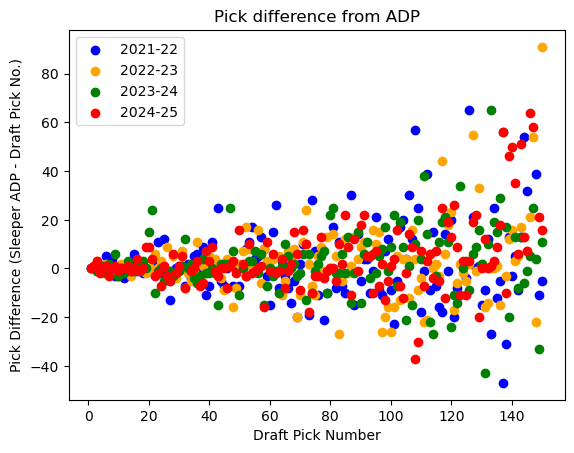

In [92]:
import matplotlib.pyplot as plt

overall_draft_data_21_22 = overall_draft_data[overall_draft_data['Season'] == '2021-22']
overall_draft_data_22_23 = overall_draft_data[overall_draft_data['Season'] == '2022-23']
overall_draft_data_23_24 = overall_draft_data[overall_draft_data['Season'] == '2023-24']
overall_draft_data_24_25 = overall_draft_data[overall_draft_data['Season'] == '2024-25']

plt.scatter(overall_draft_data_21_22['pick_no'], overall_draft_data_21_22['pick_diff'], color='blue', label='2021-22')
plt.scatter(overall_draft_data_22_23['pick_no'], overall_draft_data_22_23['pick_diff'], color='orange', label='2022-23')
plt.scatter(overall_draft_data_23_24['pick_no'], overall_draft_data_23_24['pick_diff'], color='green', label='2023-24')
plt.scatter(overall_draft_data_24_25['pick_no'], overall_draft_data_24_25['pick_diff'], color='red', label='2024-25')

plt.xlabel('Draft Pick Number')
plt.ylabel('Pick Difference (Sleeper ADP - Draft Pick No.)')
plt.title('Pick difference from ADP')
plt.legend()
plt.show()


Pie Graph for positions drafted per round (per player)

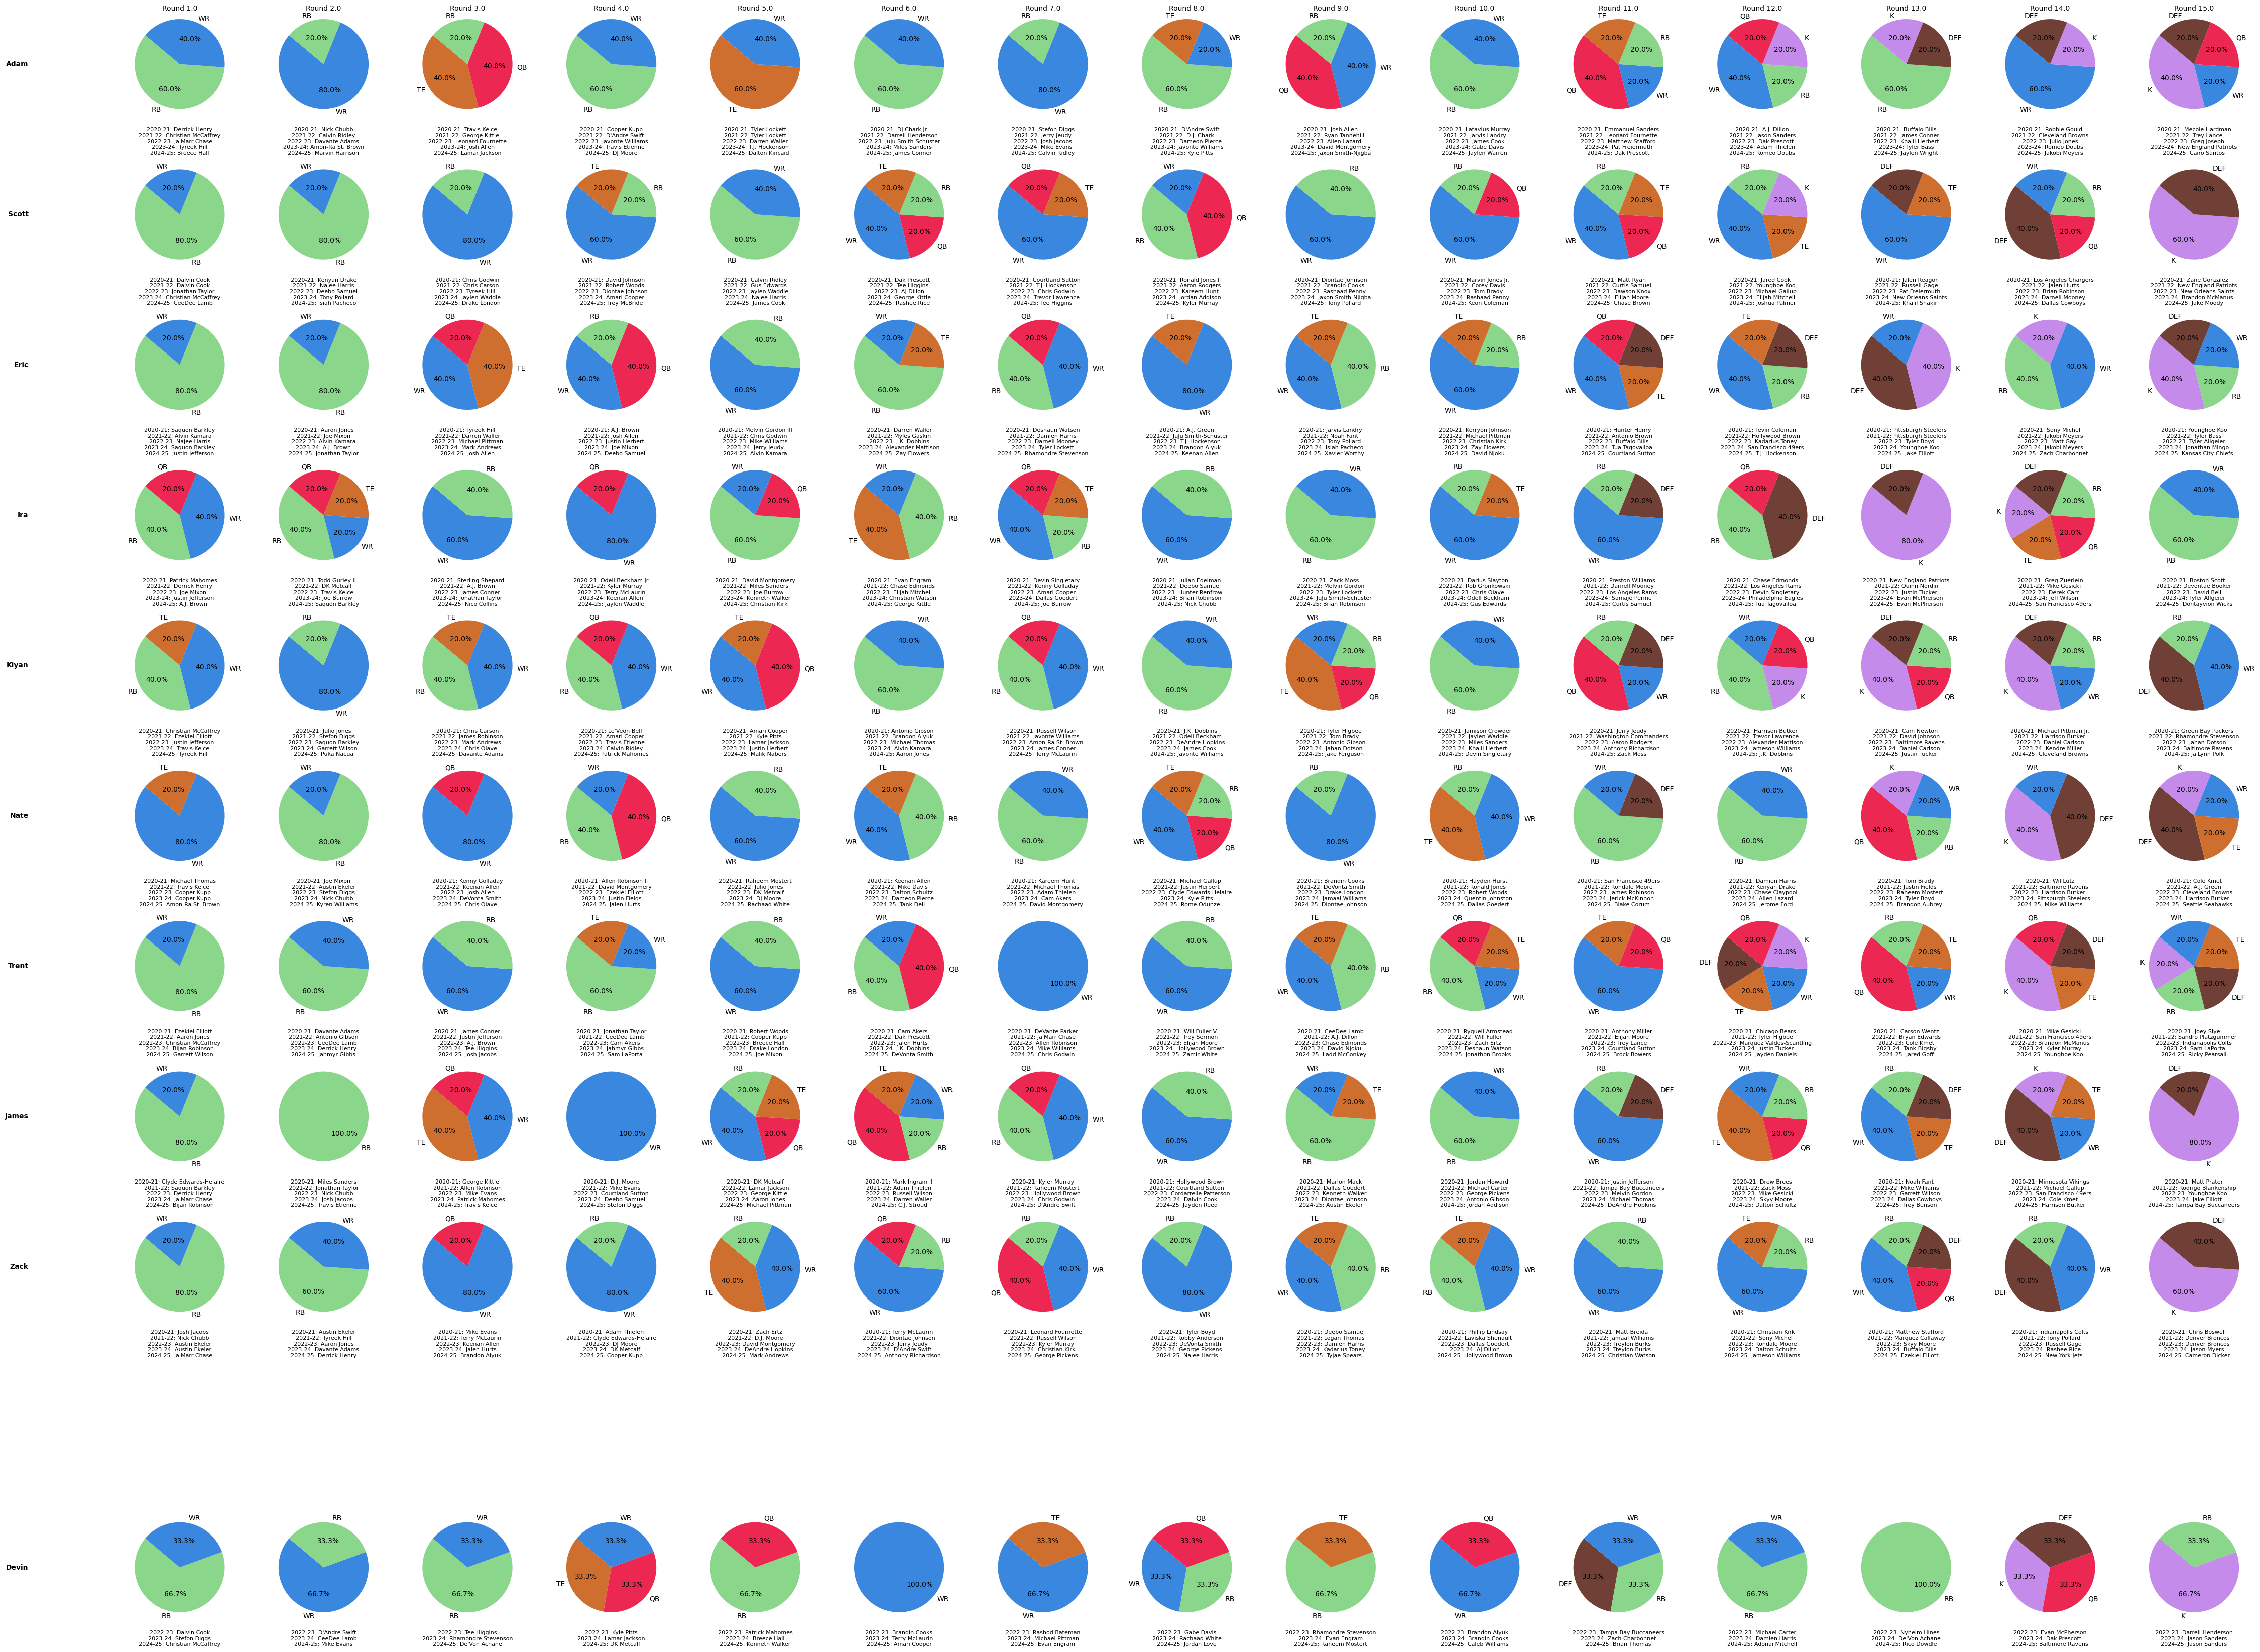

In [ ]:
scott_draft_data = overall_draft_data[overall_draft_data['picked_by'] == 'Scott']
fantasy_leaguemates = overall_draft_data['picked_by'].unique()
mask = fantasy_leaguemates != 'Logan'
fantasy_leaguemates = fantasy_leaguemates[mask] # Exclude Logan
draft_rounds = sorted(scott_draft_data['round'].unique())

# Fixed colors for positions
position_colors = {
    'QB': "#ec2752",
    'RB': "#8ad68a",
    'WR': "#3a87df",
    'TE': "#cf6f2f",
    'DEF': "#704036",
    'K': "#c58beb"
}

fig, axes = plt.subplots(len(fantasy_leaguemates), len(draft_rounds), figsize=(3 * len(draft_rounds), 3 * len(fantasy_leaguemates)))


# If there's only one row or one col, make sure axes is 2D
if len(fantasy_leaguemates) == 1:
    axes = [axes]
if len(draft_rounds) == 1:
    axes = [[ax] for ax in axes]

for row_idx, leaguemate in enumerate(fantasy_leaguemates):
    player_data = overall_draft_data[overall_draft_data['picked_by'] == leaguemate]
    
    for col_idx, rnd in enumerate(draft_rounds):
        ax = axes[row_idx][col_idx]
        round_data = player_data[player_data['round'] == rnd]
        round_data = round_data.sort_values(by='Season')
        
        if round_data.empty:
            ax.axis('off')
            continue
        
        position_counts = round_data['position'].value_counts()
        colors = [position_colors[pos] for pos in position_counts.index]

        # Pie chart
        ax.pie(position_counts, labels=position_counts.index, autopct='%1.1f%%',
               startangle=140, colors=colors)
        
        # Titles: top row gets round numbers
        if row_idx == 0:
            ax.set_title(f'Round {rnd}', fontsize=10)
        ax.axis('equal')
        
        # Left column gets leaguemate labels
        if col_idx == 0:
            ax.annotate(leaguemate, xy=(-0.8, 0.5), xycoords='axes fraction',
                        ha='right', va='center', fontsize=10, weight='bold')
        
        # Player names under pie
        player_list = []
        for index, row in round_data.iterrows():
            player_list.append(f"{row['Season']}: {row['name']}")

        players_str = "\n".join(player_list)
        ax.text(0, -1.4, players_str, ha='center', va='top', fontsize=8, wrap=True)

plt.tight_layout()
plt.show()